In [1]:
import numpy
import numpy as np
from abcsmcbare import abcsmc
from abcsmcbare import input_output
from abcsmcbare import kernels
from abcsmcbare import abcModel
from abcsmcbare import tolerance
from abcsmcbare import plotter
from abcsmcbare.KernelType import KernelType
from abcsmcbare.PriorType import PriorType
from abcsmcbare.Prior import Prior

import matplotlib
%matplotlib inline
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import re

%load_ext autoreload
%autoreload 2
matplotlib.rcParams['savefig.dpi'] = 3 * matplotlib.rcParams['savefig.dpi']

/Users/oofaish/Projects/jupyter/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
pickling = True
plot = True
plotTimeSeries = True
debug = 1#or 0 or 2 (higher the more details)
randomSeed = None #or an integer
timing = False
fname = "_results_"  # outfolder
custom_kernel = False
restart = False
mode = 0

if randomSeed is not None:
    print "#### Seeding random number generator : ", randomSeed
    numpy.random.seed(randomSeed)

modelKernel = 0.7
nparticles = 200

kernel = KernelType.component_wise_uniform  #check out kernalType.py

nbatch = 10

5.0


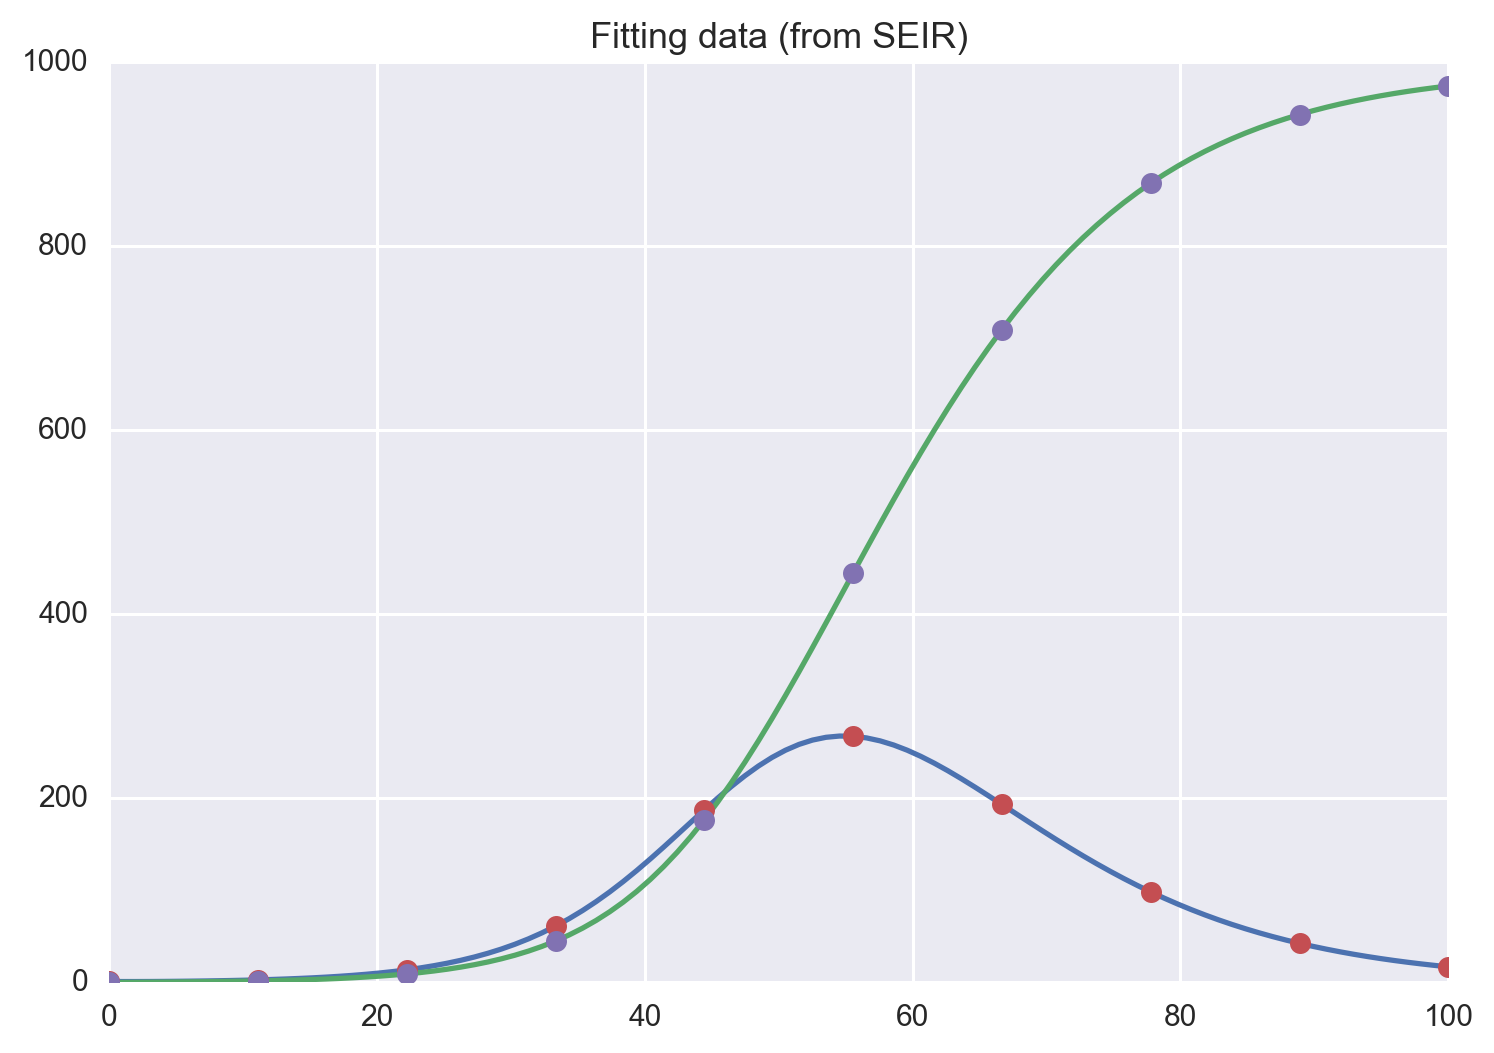

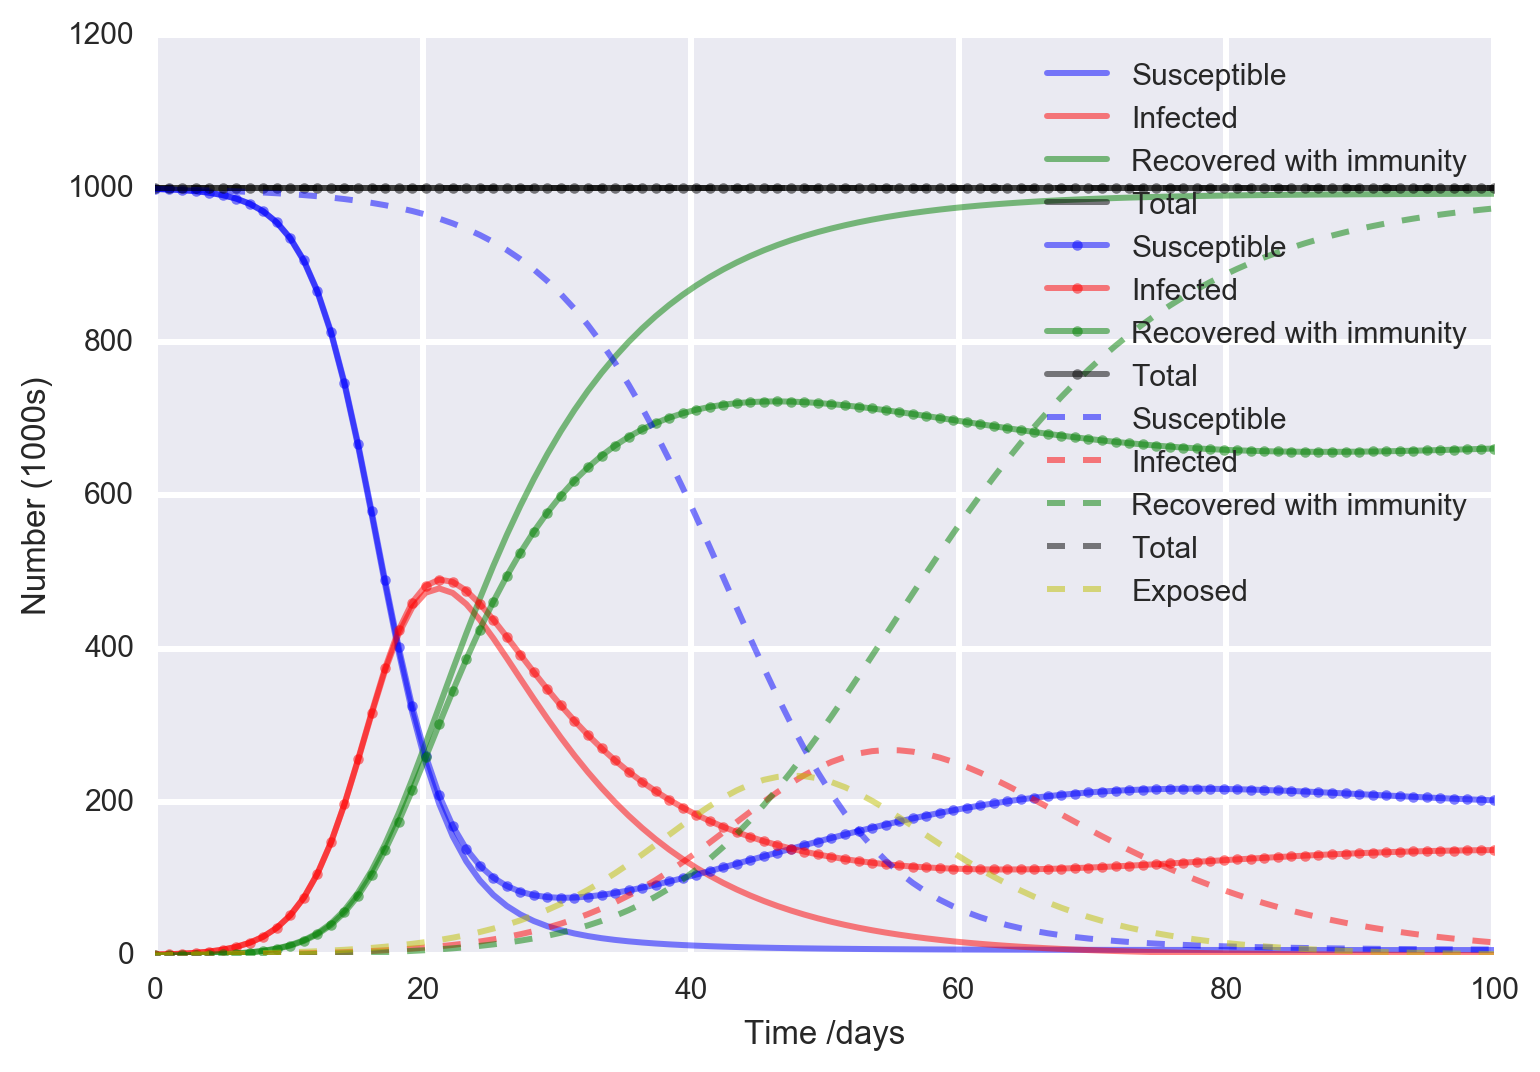

In [3]:
def doAPlot(fig, t,toPlots,labels,line='-'):

    ax = fig.add_subplot(111)#, axis_bgcolor='#dddddd', axisbelow=True)
    colors = ['b','r','g','k','y']
    for i,toPlot in enumerate(toPlots):
        ax.plot(t, toPlot, colors[i] + line, alpha=0.5, lw=2, label=labels[i])
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    #ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
E0 = 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
#Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
#1/gamma: average infectious period
#beta, gamma = 0.2, 1./10.0
#beta, gamma = 0.7, 1./10.0

betaI, gammaI, epsI, f = 2.0, 10.0, 7.0, 1.0/50.0

#Birth rate, and death rate
B, mu = 5, 0.005
B, mu = 0, 0

#1/eps is average latent period
#eps = 1/7.0

#how quickly do you fall back to being susiptible again.
#f = 1/50.0

# A grid of time points (in days)
finalT = 100.0
t  = np.linspace(0, finalT, 100)
t2 = np.linspace(0, finalT, 10)

# SIR, no latent period, but with reocevered becoming suspitible again
def deriv_SIR(y, t, N, betaI, gammaI, B, mu,f):
    
    '''GOD HORRIBLE HACK, BUT I LIKE DAYS RATHER THAN 1/DAYS'''
    beta = 1/betaI
    gamma = 1/gammaI
    #f = 1/fI
    
    #print betaI, gammaI, fI
    
    S, I, R = y
    Nt = S + I + R
    dSdt = B-beta * S * I / Nt - mu * S + f * R
    dIdt = beta * S * I / Nt - gamma * I - mu * I
    dRdt = gamma * I - mu * R - f * R
    return dSdt, dIdt, dRdt

# SIR, no latent period, recovered are always recovered
def deriv_SIR_basic(y, t, N, beta, gamma, B, mu):
    return deriv_SIR(y, t, N, beta, gamma, B, mu, 0)

#SIR, with latent period, and susiptible becoming potentially ill again.
def deriv_SEIR(y, t, N, betaI, gammaI, B, mu, f, epsI):
    S, E, I, R = y
    Nt = S + E + I + R
    
    beta  = 1/betaI
    gamma = 1/gammaI
    #f     = 1/fI
    eps  = 1 / epsI

    dSdt = B-beta * S * I / Nt - mu * S + f * R
    dEdt = beta * S * I / Nt - (eps + mu) * E 
    dIdt = eps * E - (gamma + mu) * I
    dRdt = gamma * I - mu * R - f * R
    return dSdt, dEdt, dIdt, dRdt

print (1/betaI)/(1/gammaI)

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret_basic = scipy.integrate.odeint(deriv_SIR_basic, y0, t, args=(N, betaI, gammaI, B, mu))
ret_SIR = scipy.integrate.odeint(deriv_SIR, y0, t, args=(N, betaI, gammaI, B, mu, f))


y0 = S0, E0, I0, R0
ret_SEIR  = scipy.integrate.odeint(deriv_SEIR, y0, t, args=(N, betaI, gammaI, B, mu, 0, epsI))
ret_SEIR2 = scipy.integrate.odeint(deriv_SEIR, y0, t2, args=(N, betaI, gammaI, B, mu, 0, epsI))

fig2 = plt.figure()#(facecolor='w')
plt.hold(True)
plt.title('Fitting data (from SEIR)')
S, E, I, R = ret_SEIR.T
S2, E2, I2, R2 = ret_SEIR2.T
plt.plot(t,I)
plt.plot(t,R)
plt.plot(t2,I2,'o')
plt.plot(t2,R2,'o')


S, I, R = ret_basic.T
fig1 = plt.figure(facecolor='w')
doAPlot(fig1,t,[S,I,R,S+I+R],['Susceptible','Infected','Recovered with immunity','Total'])
S, I, R = ret_SIR.T
#S2, I2, R2 = ret2.T
doAPlot(fig1,t,[S,I,R,S+I+R],['Susceptible','Infected','Recovered with immunity','Total'],line='.-')
#doAPlot(fig2,t,[S2,I2,R2,S2+I2+R2],['Susceptible','Infected','Recovered with immunity','Total'],line='.-')

S, E, I, R = ret_SEIR.T
#fig3 = plt.figure()#(facecolor='w')
doAPlot(fig1,t,[S,I,R,S+E+I+R,E],['Susceptible', 'Infected','Recovered with immunity','Total','Exposed'],line='--')



In [4]:
#gamma = 1/recovery period in days
#beta  = contact rate (number of contacts per day)
#B and mu birth and death rate
#eps = 1/Latent Priod
#f   = 1/fallback period

#betaI, gammaI, epsI, fI = 2.0, 10.0, 7.0, 50.0

pDaysBeforeContact = Prior(type=PriorType.uniform,  lower_bound=1.0, upper_bound=10.0)
pRecoveryPeriod    = Prior(type=PriorType.uniform,  lower_bound=1.0, upper_bound=30.0)
pLatentPeriod      = Prior(type=PriorType.uniform,  lower_bound=1.0, upper_bound=10.0)
pFallbackPeriod    = Prior(type=PriorType.uniform,  lower_bound=30.0, upper_bound=200.0)
pFallbackRate      = Prior(type=PriorType.uniform,  lower_bound=0.0, upper_bound=1.0)
pFallbackPeriodConstant    = Prior(type=PriorType.constant,  value=np.Inf)
pFallbackRateConstant    = Prior(type=PriorType.constant,  value=0)
pBirth             = Prior(type=PriorType.constant, value=0.0)
pDeath             = Prior(type=PriorType.constant, value=0.0)
pPopulation        = Prior(type=PriorType.constant, value=1000.0)

def dist_metric(d,x,params,model):
    S2, E2, I2, R2 = x
    allPoints = np.concatenate((I2-d[:,-2],R2-d[:,-1]))
    distance = np.sum(allPoints**2)**0.5/len(allPoints)
    #if np.isnan(distance):
    #    print model.name, params
    return distance

def simulation_SIR(paramsArray, pool=None):
    y0 = S0, I0, R0
    r = [scipy.integrate.odeint(deriv_SIR, y0, t2, args=tuple(x)) for x in paramsArray]
    return np.array(r)

def simulation_SIR_basic(paramsArray, pool=None):
    y0 = S0, I0, R0
    r = [scipy.integrate.odeint(deriv_SIR_basic, y0, t2, args=tuple(x)) for x in paramsArray]
    return np.array(r)

def simulation_SEIR(paramsArray, pool=None):
    y0 = S0, E0, I0, R0
    r = [scipy.integrate.odeint(deriv_SEIR, y0, t2, args=tuple(x)) for x in paramsArray]
    return np.array(r)

  
priors_SIR       = [pPopulation, pDaysBeforeContact, pRecoveryPeriod, pBirth, pDeath, pFallbackRate] 
priors_SIR_basic = [pPopulation, pDaysBeforeContact, pRecoveryPeriod, pBirth, pDeath] 
priors_SEIR      = [pPopulation, pDaysBeforeContact, pRecoveryPeriod, pBirth, pDeath, pFallbackRateConstant, pLatentPeriod] 

models = []

model_SIR = abcModel.AbcModel(name='SIR',
                           simulationFn=simulation_SIR,
                           distanceFn=dist_metric,
                           nparameters=6,
                           prior=priors_SIR)

model_SIR_basic = abcModel.AbcModel(name='SIR Basic',
                           simulationFn=simulation_SIR_basic,
                           distanceFn=dist_metric,
                           nparameters=5,
                           prior=priors_SIR_basic)

model_SEIR = abcModel.AbcModel(name='SEIR',
                           simulationFn=simulation_SEIR,
                           distanceFn=dist_metric,
                           nparameters=7,
                           prior=priors_SEIR)



if True:
    models = [model_SIR_basic, model_SEIR]
else:
    models = [model_SEIR]

names  = [x.name for x in models]
nmodels = len(models)
modelprior = [1 / float(nmodels)] * nmodels


# set the required kernel functions
kernelfn = kernels.get_kernel
kernelpdffn = kernels.get_parameter_kernel_pdf
perturbfn = kernels.perturb_particle

In [5]:
parms       = [1000, 2.0, 10.0, 0, 0, 0, 7.0]
parms_basic = [1000, 2.0, 10, 0, 0] 
(dist_metric(simulation_SEIR((parms,))[0],ret_SEIR2.T, None, None),
dist_metric(simulation_SIR_basic((parms_basic,))[0],ret_SEIR2.T, None, None))

(0.0, 3120.1126715667156)

Run the actual ABC SMC
===
If you pass in just one of the models, etc then it just does parameter inference, if you pass in two models, it does model selection

Certain files will get saved to disk:
- allResults (which is a list containing 'abcsmcresults' classes of each of the populations run)
- a folder called 'copy' which is useful if you are doing a restart (it always contains useful points to rstart from the last population - just set restart to True, make sure your epsilon starts from the right point - so if you stopped at epsilon=2.0, then start the next one at 2.0 or slightly below that)

In [6]:
restart = False
if not restart:
    fname = '_results_'
    niter = 40
    firstEpsilon = 50
    lastEpsilon  = 5#rstEpsilon * 0.01
else:
    fname = '_results_20161018_162323'
    niter = 20
    firstEpsilon = 500.0
    lastEpsilon  = 100.0#rstEpsilon * 0.01


tol_type = 'exp'
epsilonSchedule = tolerance.Tolerance(tol_type, lastEpsilon, firstEpsilon, niter).tol

epsilonSchedule
epsilonSchedule = tolerance.Tolerance(tol_type, lastEpsilon, firstEpsilon, niter).tol

epsilonSchedule
io = input_output.InputOutput(fname, restart)
io.create_output_folders(nparticles, pickling)

abcSmcInstance = abcsmc.Abcsmc(models=models,
                               nparticles=nparticles,
                               modelprior=modelprior,
                               data=ret_SEIR2.T, # beta=info_new.beta,
                               nbatch=nbatch,
                               model_kernel=modelKernel,
                               debug=debug,
                               timing=timing,
                               io=io,
                               # distancefn=distancefn,
                               kernel_type=kernel,
                               kernelfn=kernelfn,
                               kernelpdffn=kernelpdffn,
                               perturbfn=perturbfn)


if restart:
    abcSmcInstance.fill_values(io.read_pickled(fname))

allResults = abcSmcInstance.run_schedule(epsilonSchedule,adaptiveEpsilon=False)

top folder name is _results_20161018_183840
(useful e.g. if you are restarting because in such cases this is the folder name you should pass in)
### Found special kernel case 1 for model  0 ###
### Found special kernel case 1 for model  1 ###
### iter:1, eps=3000.00, sampled=200, accepted=1.00
model marginals: [0.4900000000000003, 0.5100000000000003]
### iter:2, eps=2749.45, sampled=200, accepted=1.00
model marginals: [0.43304465542425175, 0.56695534457574792]
### iter:3, eps=2519.83, sampled=200, accepted=1.00
model marginals: [0.51000171325742605, 0.48999828674257373]
### iter:4, eps=2309.39, sampled=200, accepted=1.00
model marginals: [0.4333061476350048, 0.56669385236499514]
### iter:5, eps=2116.52, sampled=200, accepted=1.00
model marginals: [0.45967197653292946, 0.54032802346707065]
### iter:6, eps=1939.75, sampled=200, accepted=1.00
model marginals: [0.38900964019394407, 0.61099035980605565]
### iter:7, eps=1777.75, sampled=292, accepted=0.68
model marginals: [0.5155725233884836

KeyboardInterrupt: 

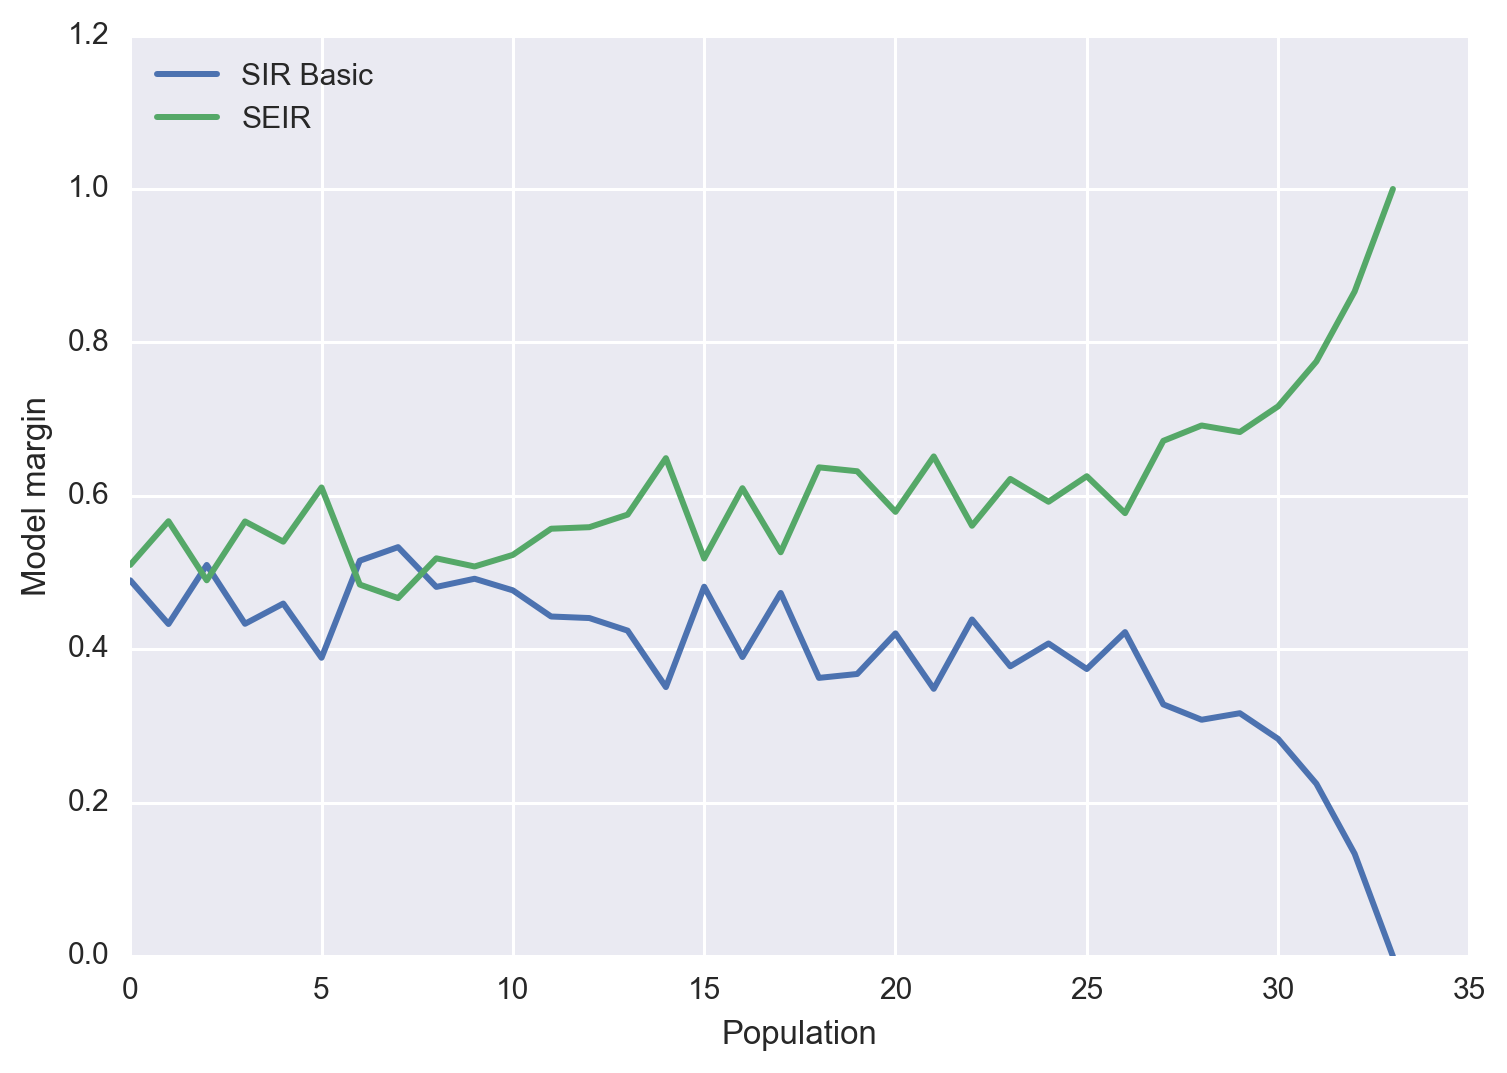

In [9]:
import pickle
allResults = pickle.load(open('_results_20161018_183840/allResults.dat','r'))
plotter.modelMarginsByPopulation(allResults,models)

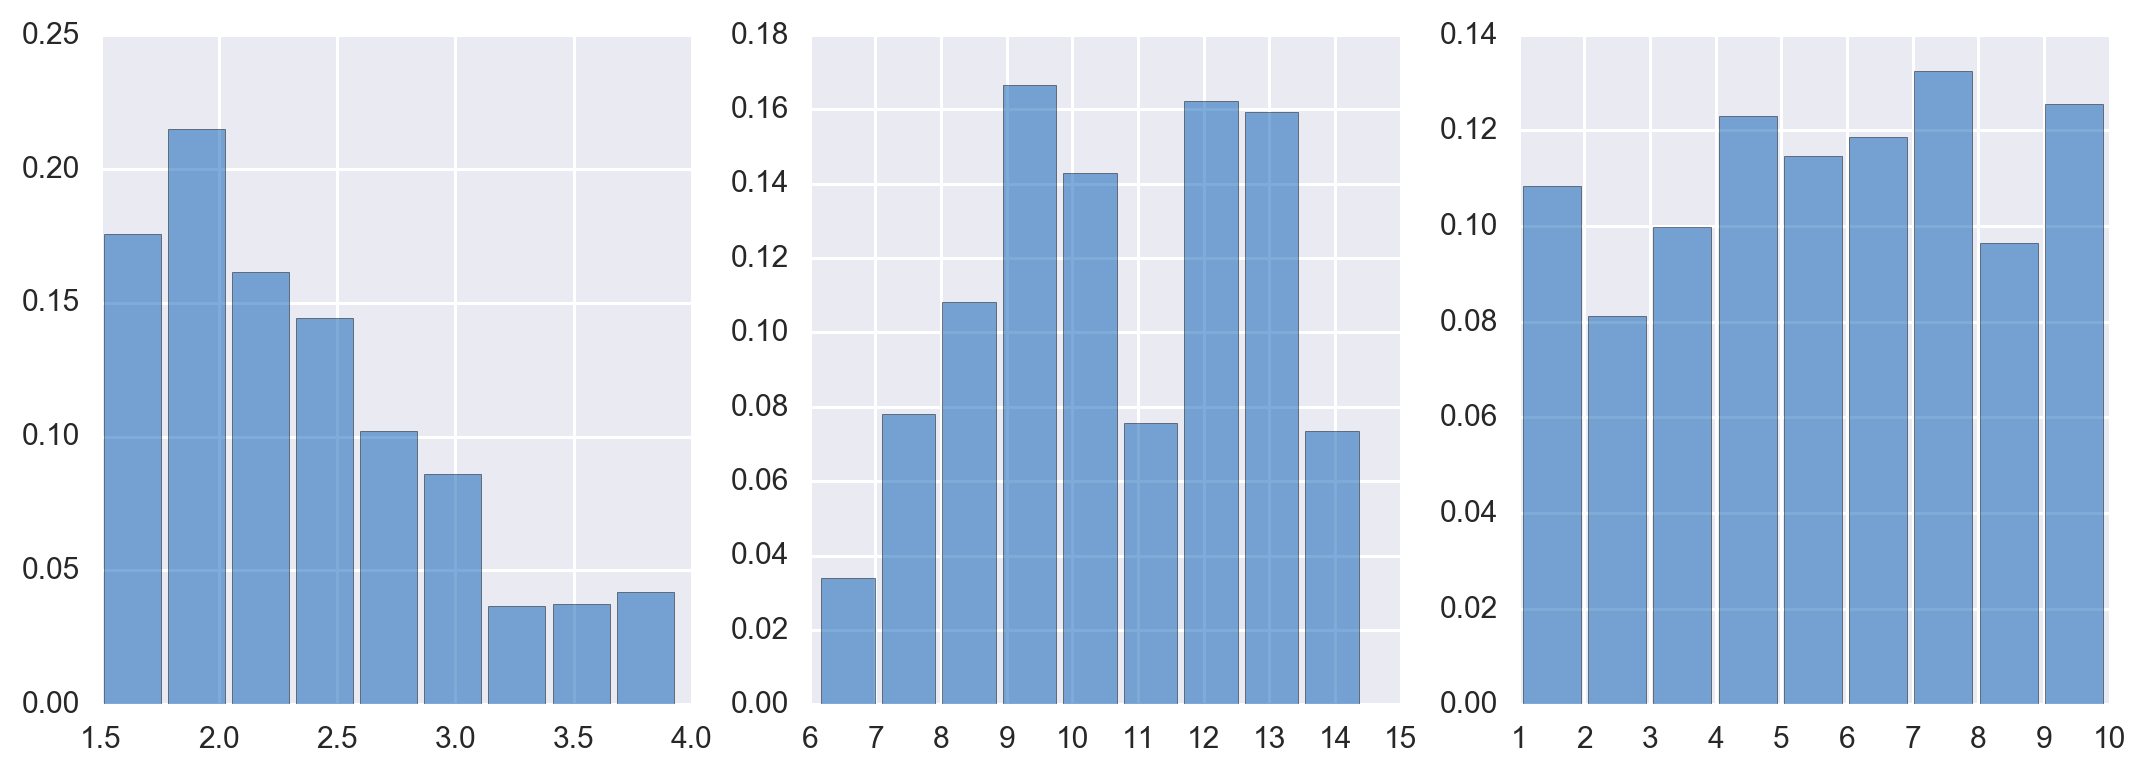

In [19]:
#plot the estimated posterior of the model 0 int he last population
plotter.plotHistogram(allResults[-1],1,models=models)

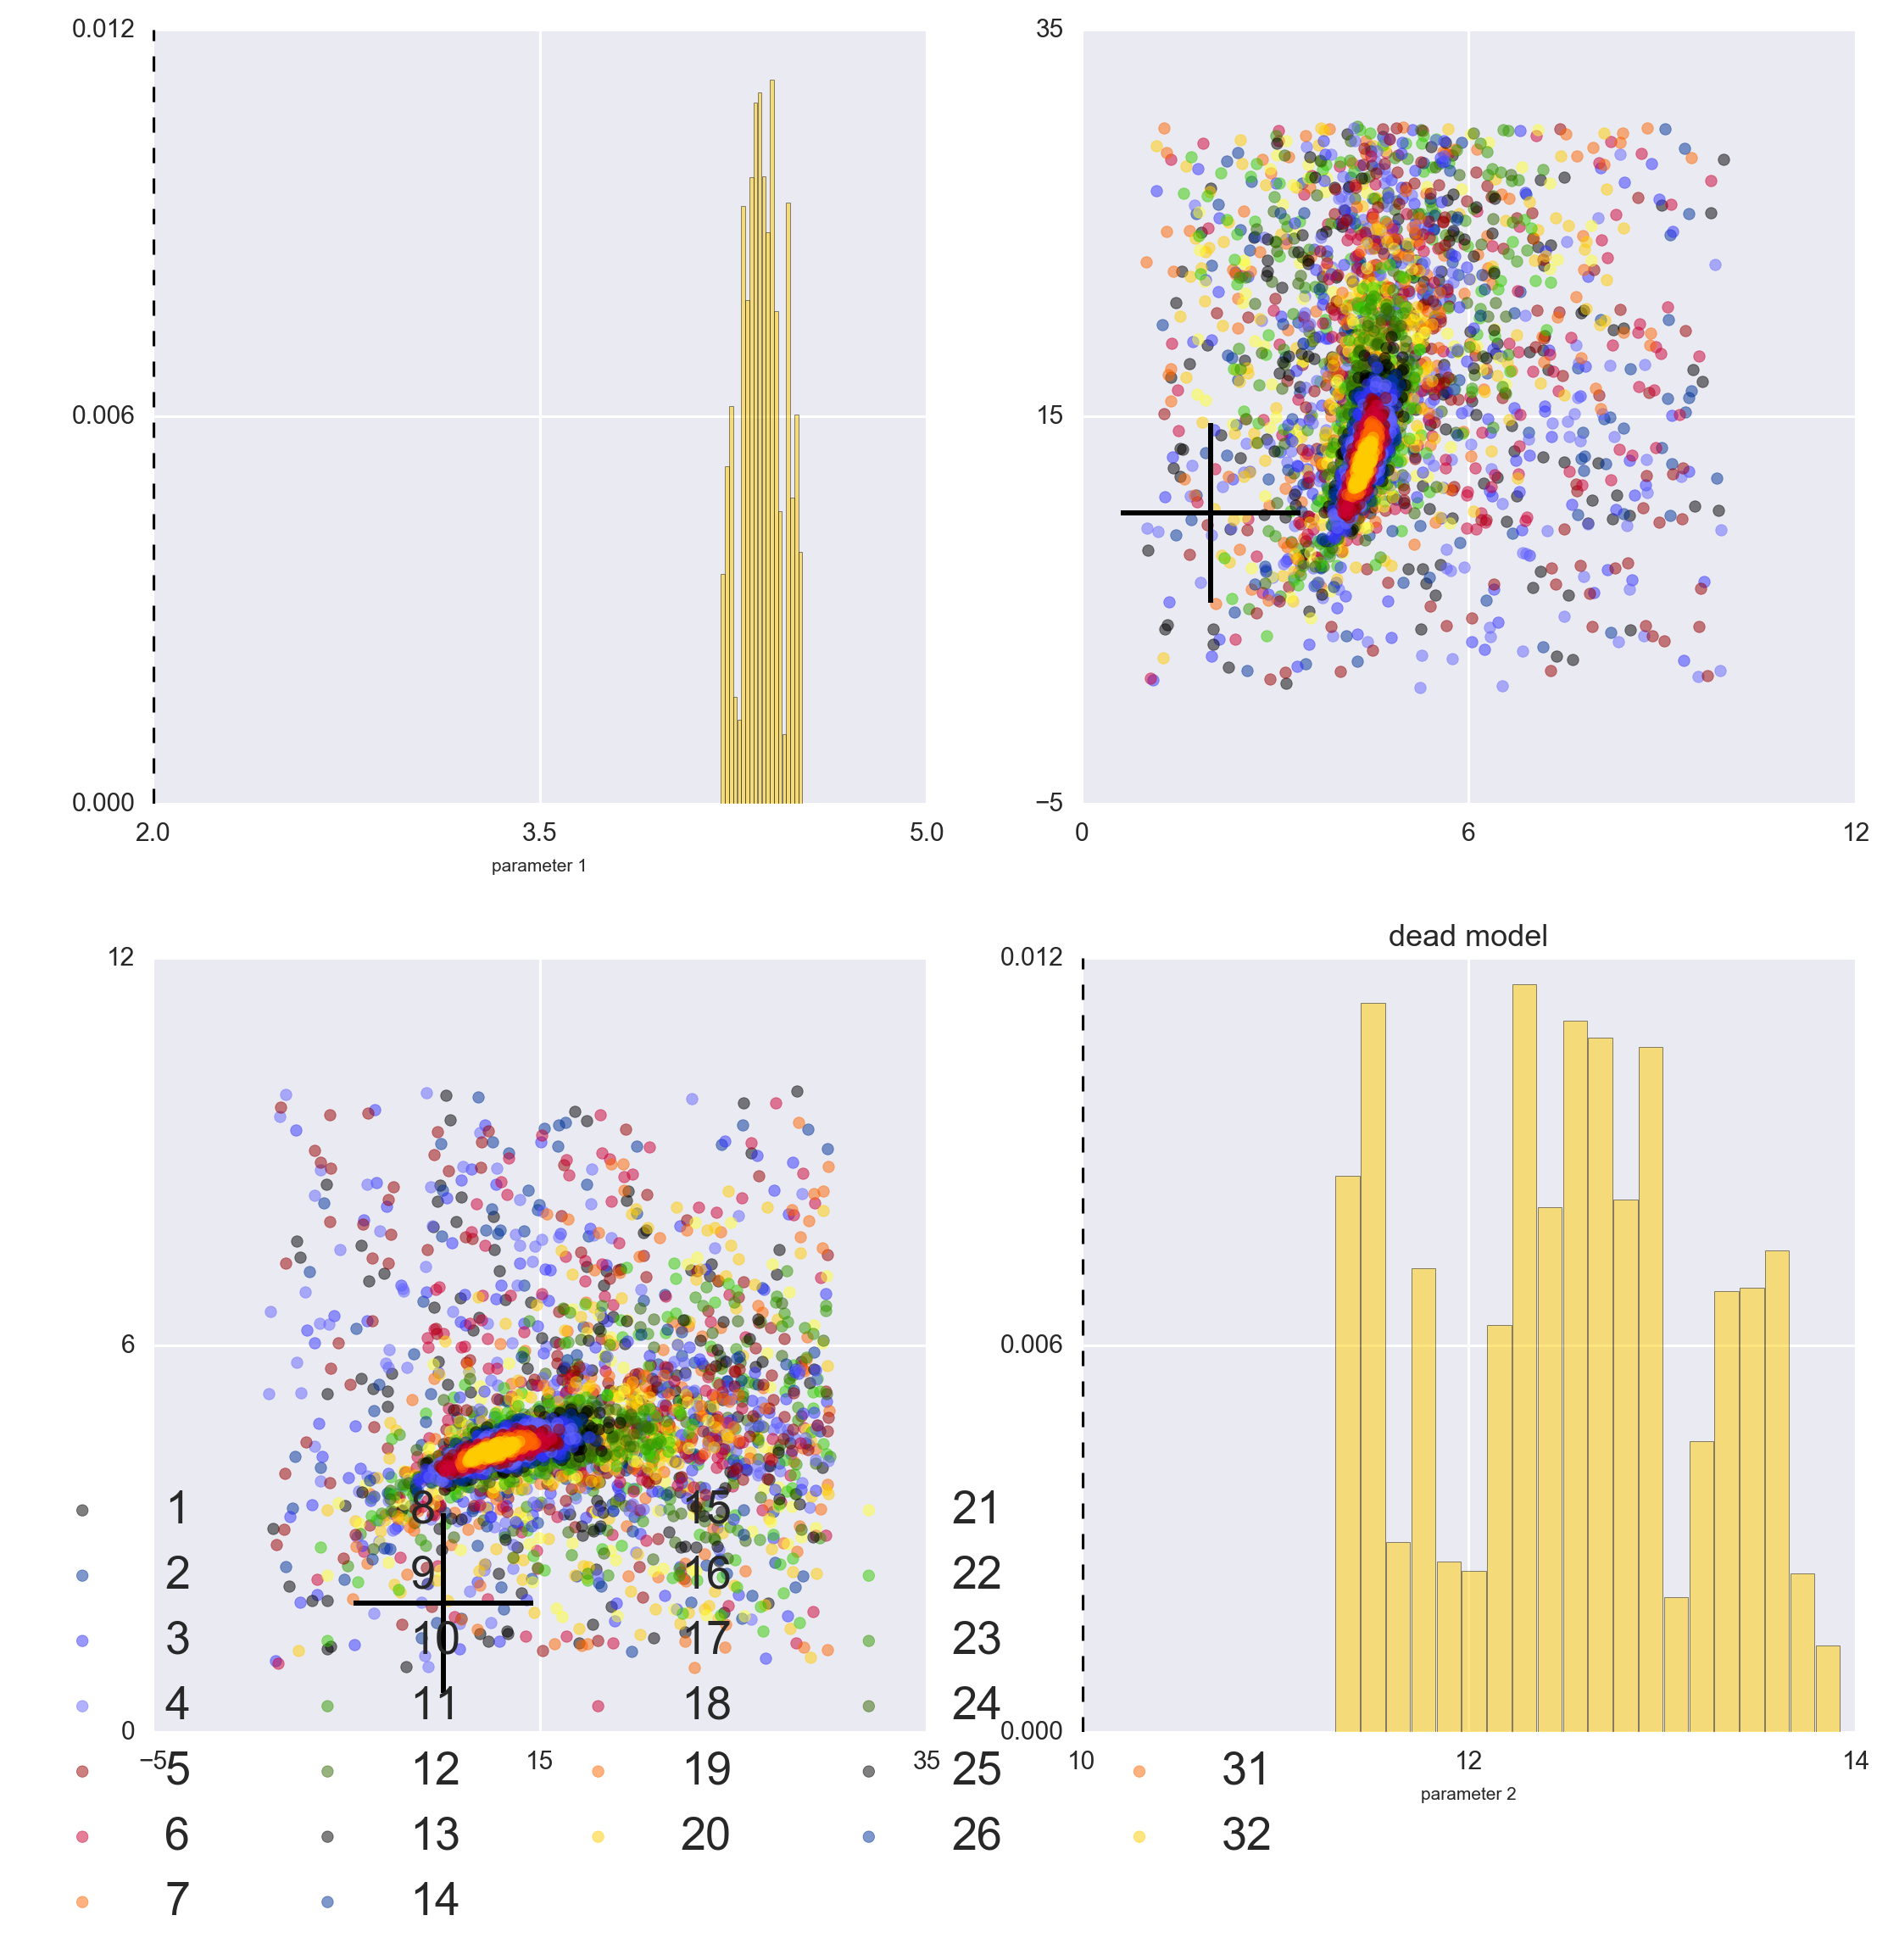

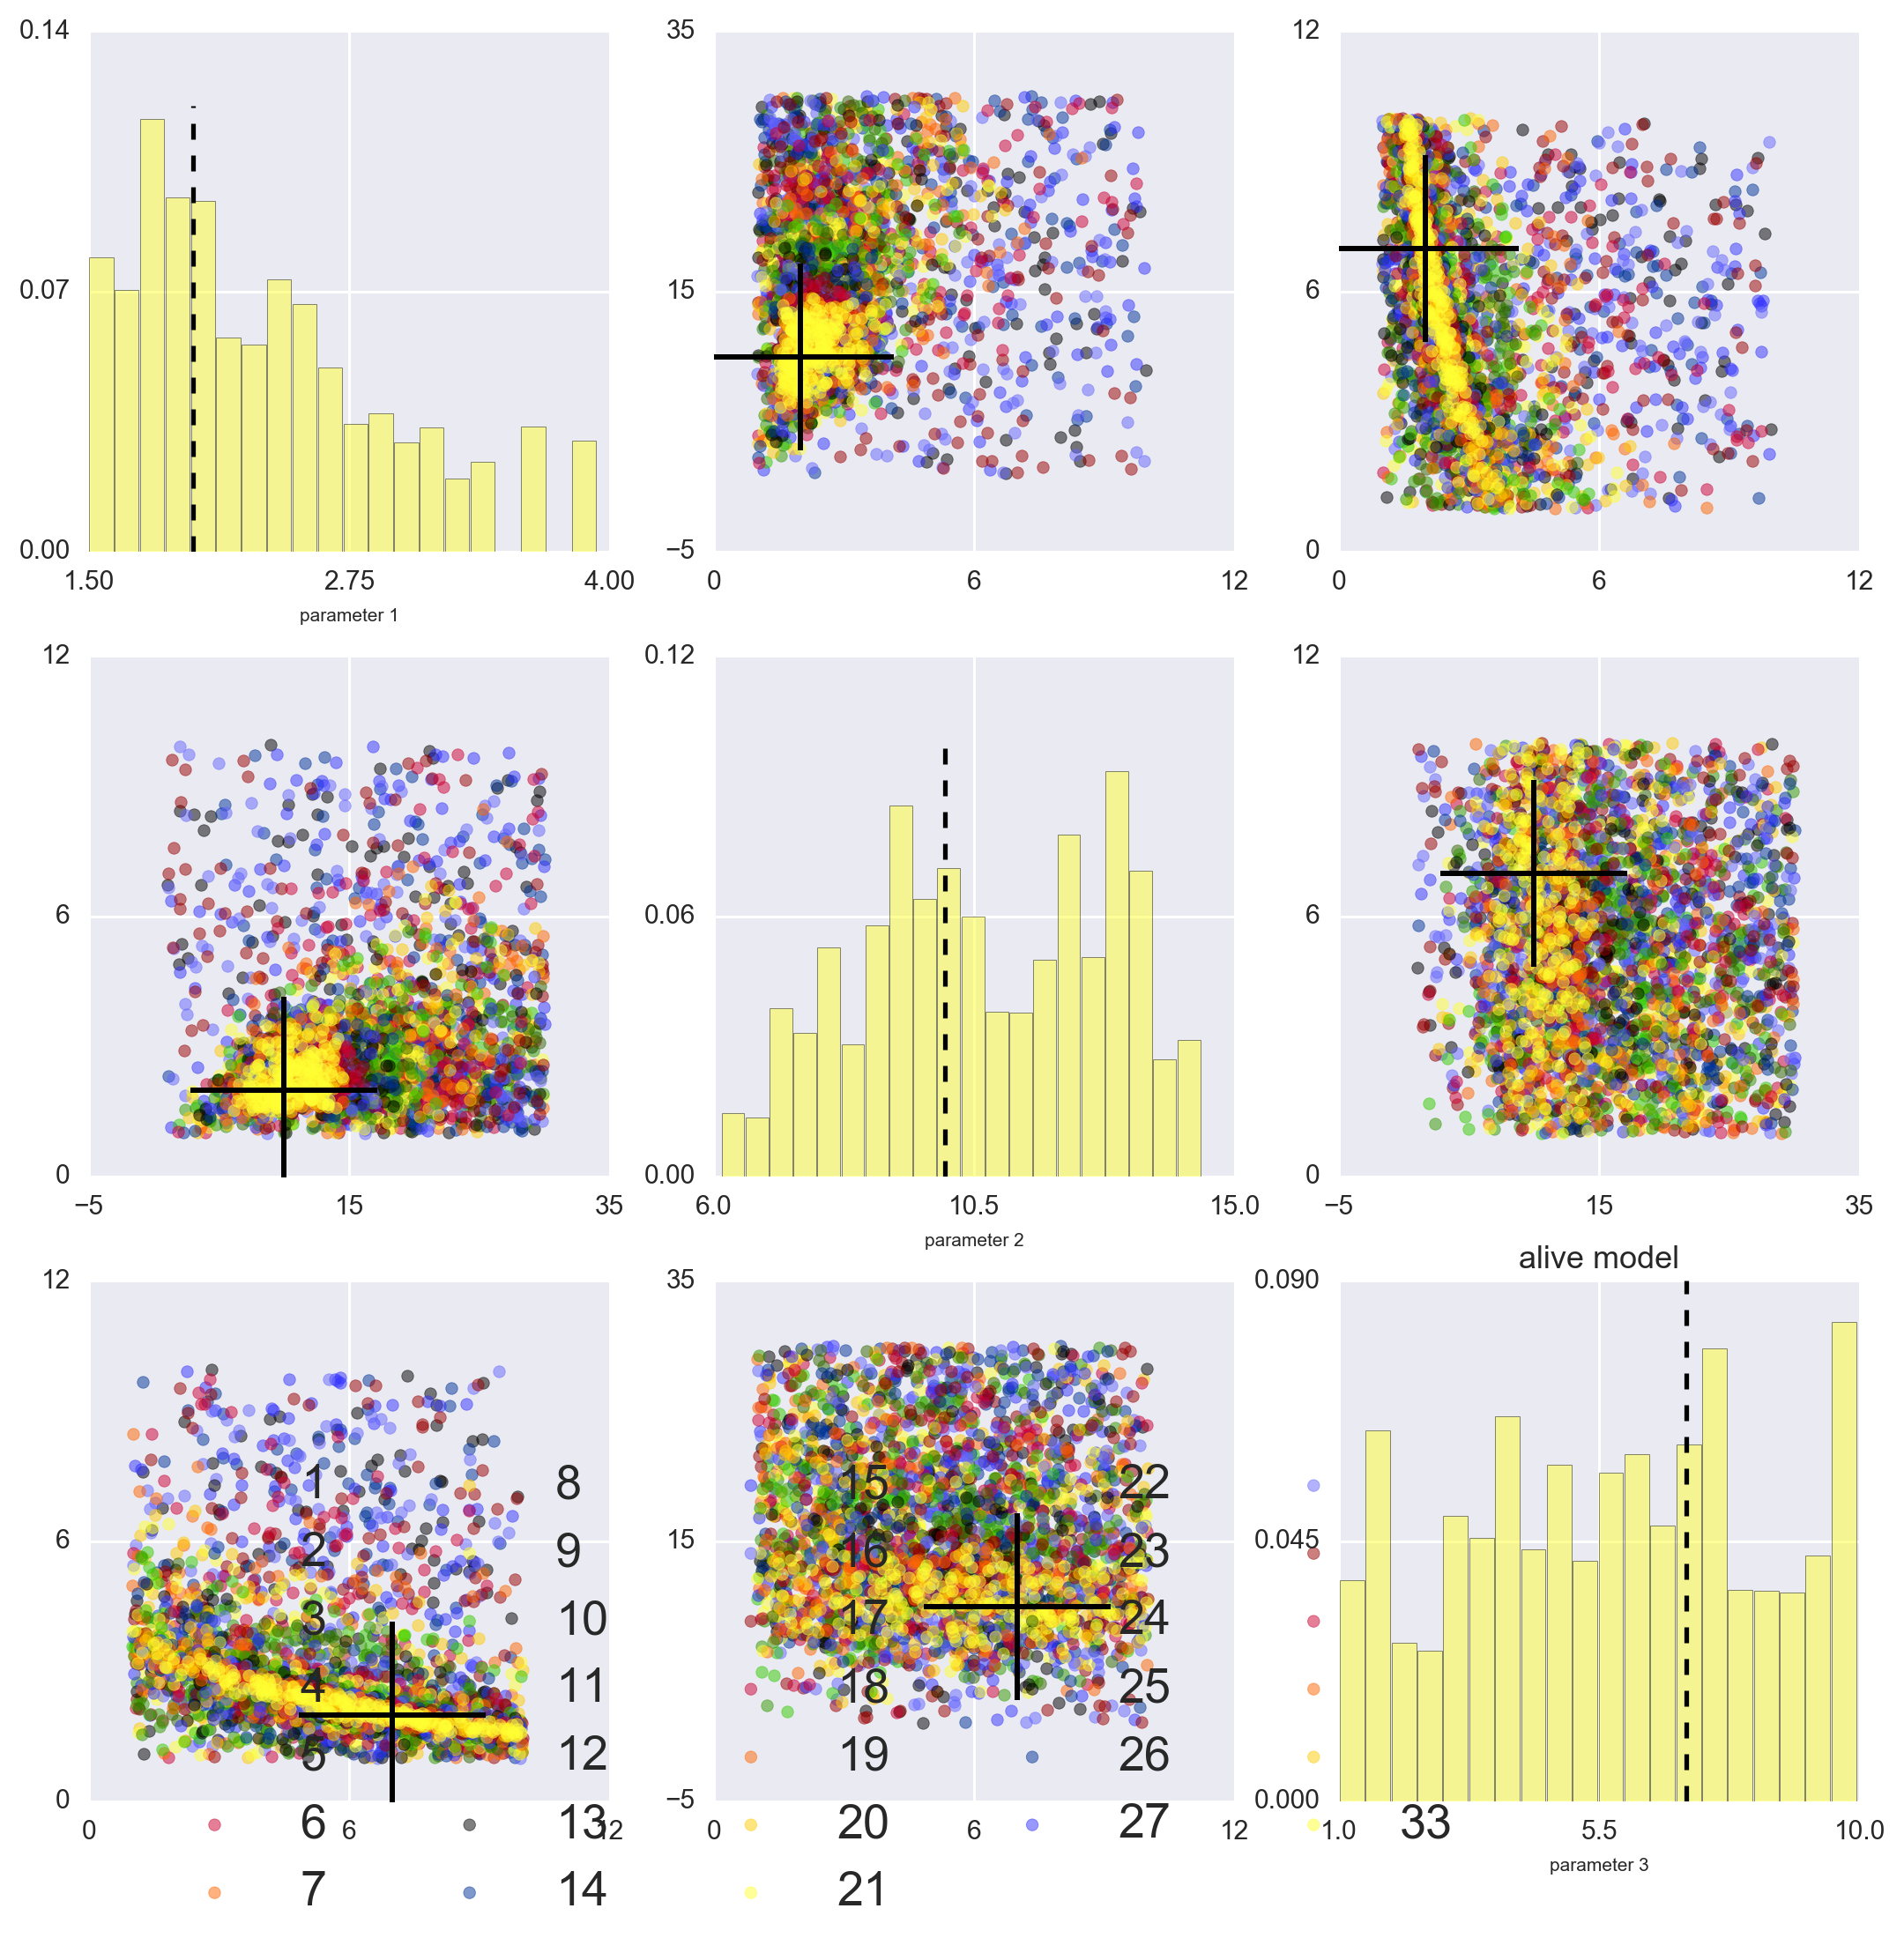

In [22]:
#do a pairplot of the parameters (for all 10 populations (hence range(10)))
plotter.doPairPlot(allResults, 0,range(1,33), models,actualValues=(2.0,10.0,7.0))
plotter.doPairPlot(allResults, 1,range(1,34), models,actualValues=(2.0,10.0,7.0))

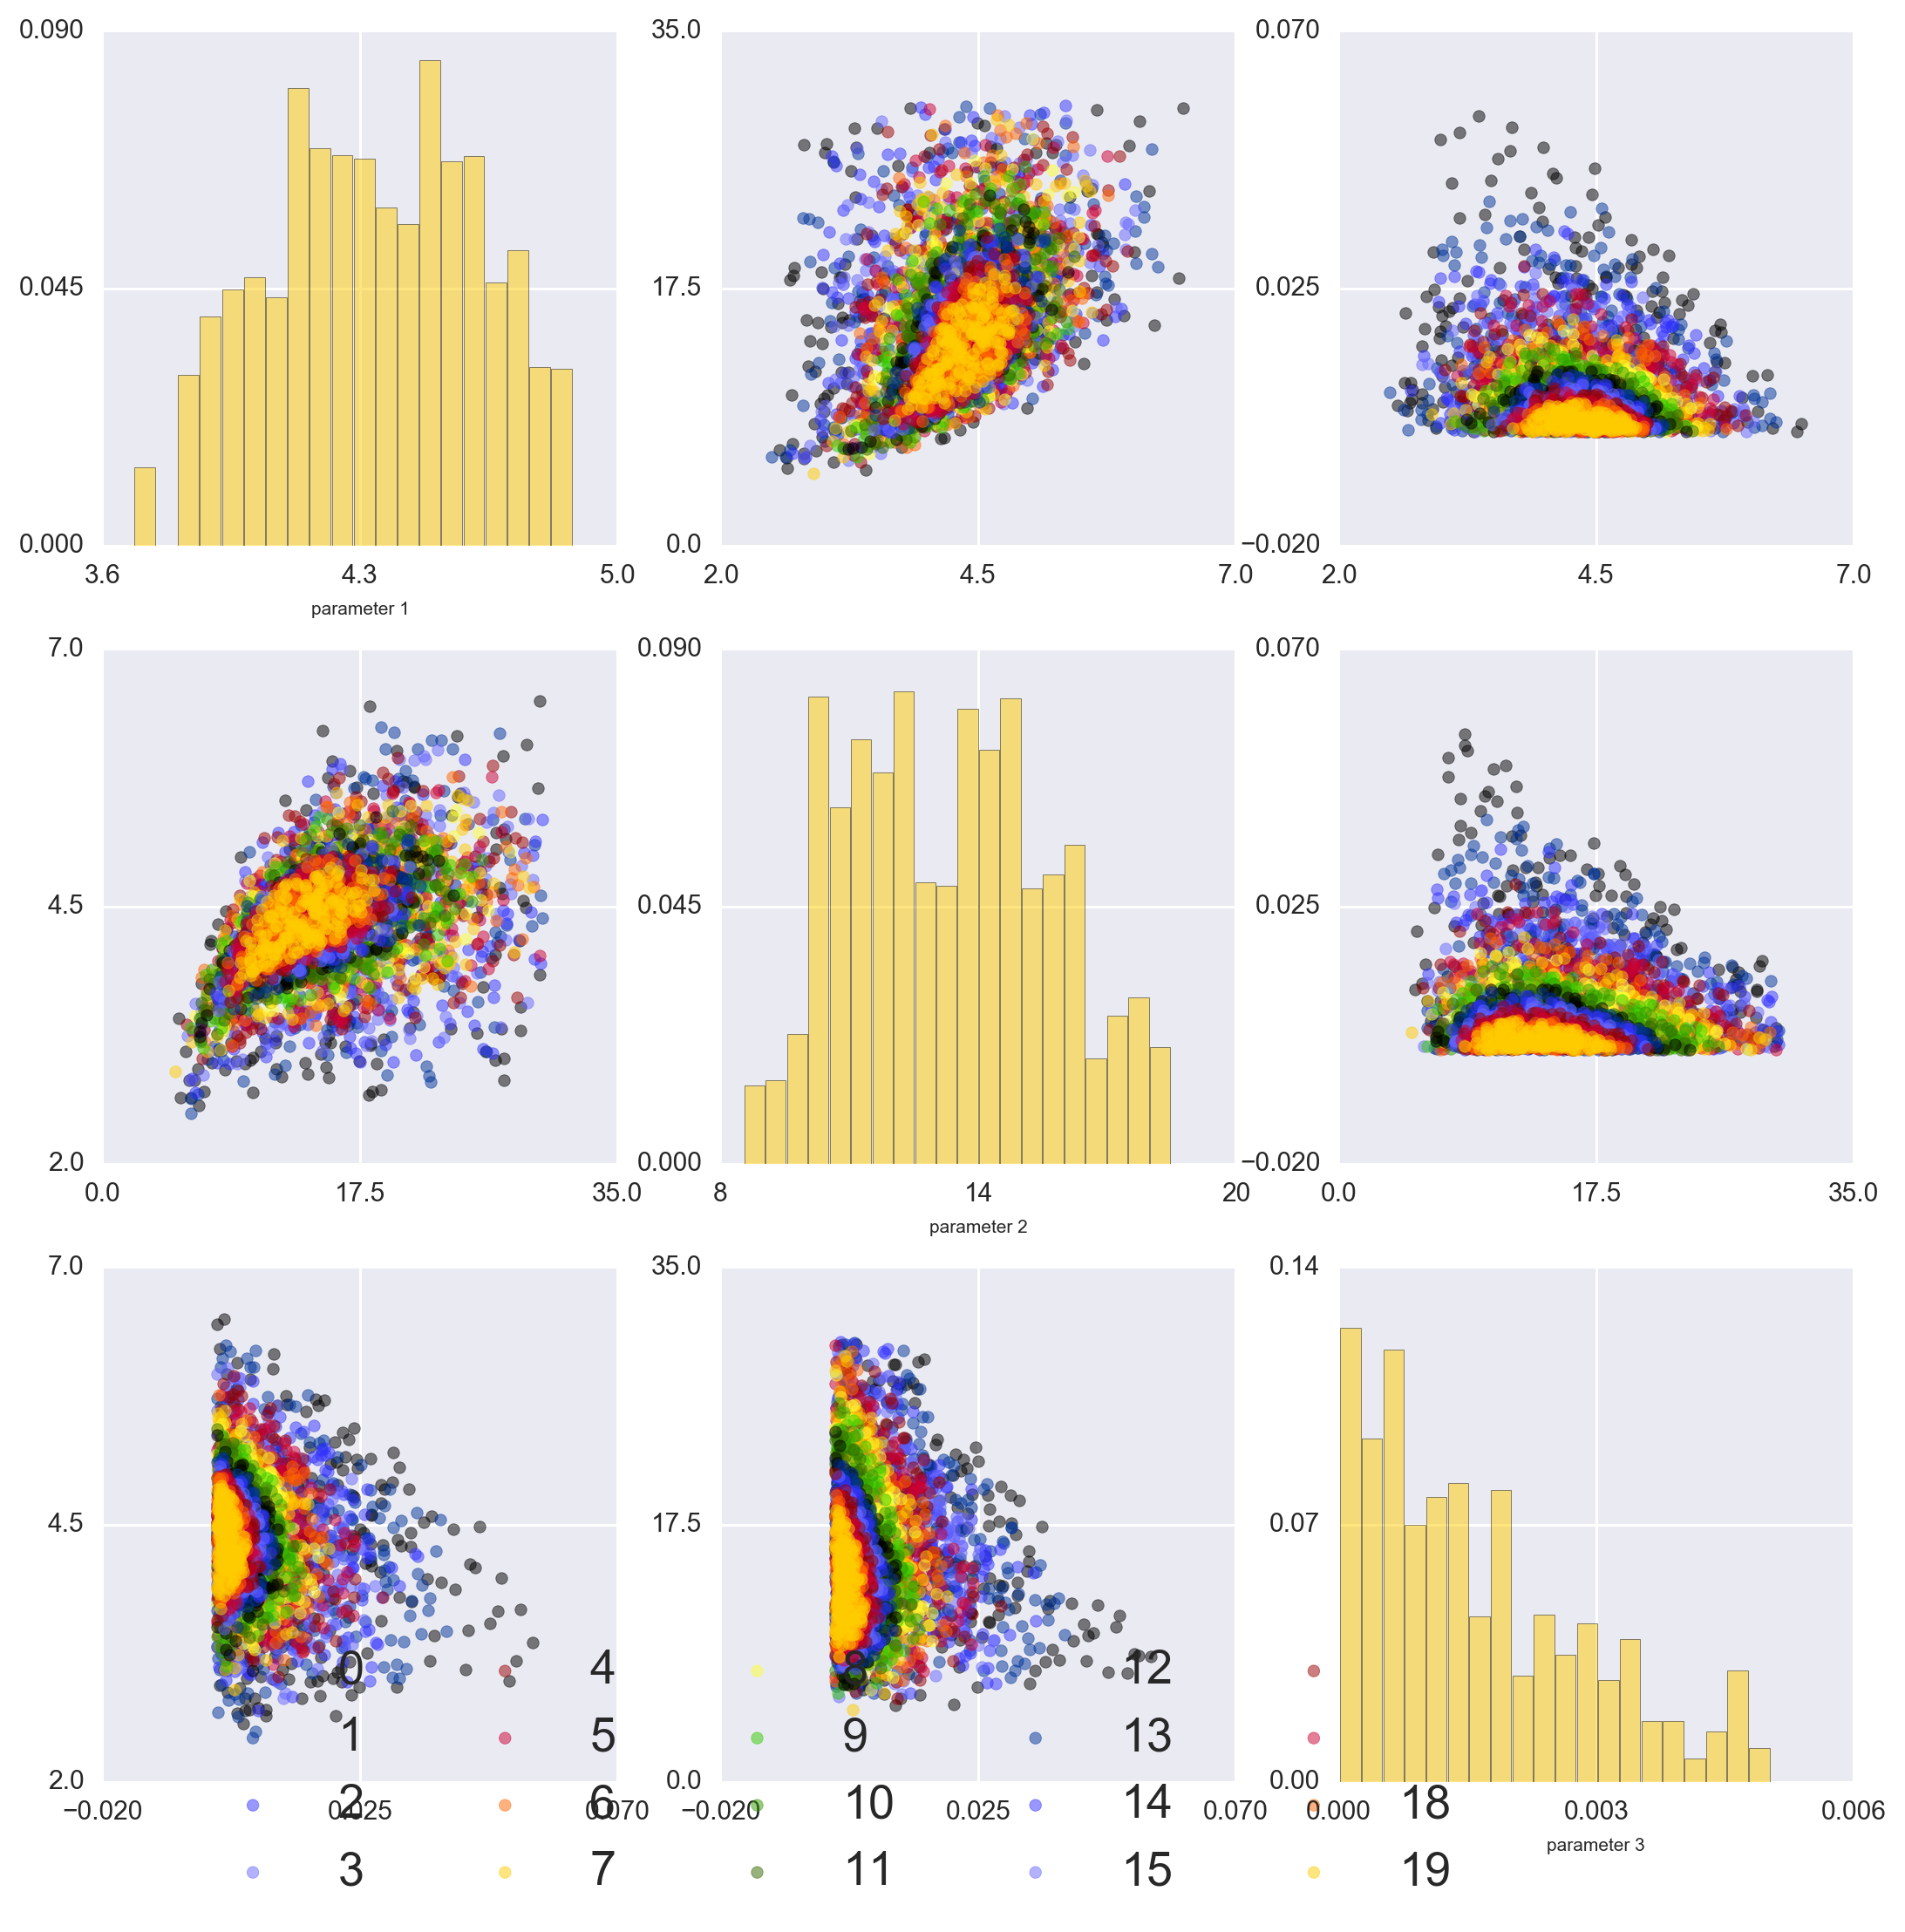

In [7]:
import pickle
allResults = pickle.load(open('_results_20161018_164621/allResults.dat','r'))
from abcsmcbare import plotter
plotter.doPairPlot(allResults, 0, range(20), models)